<a href="https://colab.research.google.com/github/xhavien/CCDEPLRL_EXERCISES_COM222ML/blob/main/Exercise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import os
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Display an image to test if the mount is successful

In [ ]:
dataset_path = "/content/drive/MyDrive/datasets/selfies"
image_dir = os.path.join(dataset_path, "imagess")
label_dir = os.path.join(dataset_path, "labels")

In [ ]:
def displayImage(image_path):
  # Path to your image file in Google Drive
  image = Image.open(image_path)

  # Display the image using matplotlib
  plt.imshow(image)
  plt.axis('off')  # Hide axes for cleaner display
  plt.show()

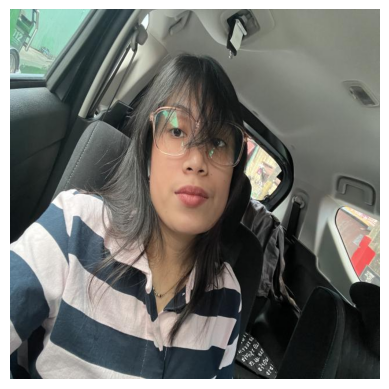

In [ ]:
displayImage('/content/drive/MyDrive/datasets/selfies/imagess/olympia_15_jpg.rf.f63aa0f67fbd4f86ec8b50c3a107b9b1.jpg')

## Check if GPU is used

In [ ]:
# Check if TensorFlow can access the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0]}")
else:
    print("No GPU available.")

TensorFlow is using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Define the image size

In [ ]:
SIZE = 640
image_size = (SIZE, SIZE)

In [ ]:
X = []
y_class = []
y_bbox = []
class_ids = set()

## Load the images and annotations

In [ ]:
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".png", ".jpeg")):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = img / 255.0

        # Load annotation
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))

            X.append(img)
            y_class.append(cls)
            y_bbox.append(bbox)
            class_ids.add(cls)

X = np.array(X, dtype=np.float32)

In [ ]:
# Map class IDs to indices
class_ids = sorted(list(class_ids))
class_to_idx = {cls: idx for idx, cls in enumerate(class_ids)}
num_classes = len(class_ids)

# # One-hot encode class labels
y_class = [class_to_idx[c] for c in y_class]
y_class = to_categorical(y_class, num_classes=num_classes)

y_bbox = np.array(y_bbox, dtype=np.float32)

## Split the dataset

In [ ]:
X_train, X_test, y_cls_train, y_cls_test, y_bbox_train, y_bbox_test = train_test_split(X, y_class, y_bbox, test_size=0.2, random_state=42)

## Build the Convolutional Neural Network

In [ ]:
input_layer = layers.Input(shape=(SIZE, SIZE, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Output 1: class probabilities
class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)

# Output 2: bounding box (x_center, y_center, width, height)
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

model = models.Model(inputs=input_layer, outputs=[class_output, bbox_output])
model.compile(
    optimizer='adam',
    loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
    metrics={'class_output': 'accuracy'}
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 638, 638,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 319, 319,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 317, 317,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 158, 158,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1597696)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 204,505,2… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │        645 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,525,769 (780.20 MB)

 Trainable params: 204,525,769 (780.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    {'class_output': y_cls_train, 'bbox_output': y_bbox_train},
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - bbox_output_loss: 0.1598 - class_output_accuracy: 0.2249 - class_output_loss: 25.8397 - loss: 26.1722 - val_bbox_output_loss: 0.0176 - val_class_output_accuracy: 0.5750 - val_class_output_loss: 1.4032 - val_loss: 1.4069
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 333ms/step - bbox_output_loss: 0.0344 - class_output_accuracy: 0.6356 - class_output_loss: 1.1096 - loss: 1.1466 - val_bbox_output_loss: 0.0489 - val_class_output_accuracy: 0.5000 - val_class_output_loss: 1.4562 - val_loss: 1.3650
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - bbox_output_loss: 0.0374 - class_output_accuracy: 0.8502 - class_output_loss: 0.4737 - loss: 0.5131 - val_bbox_output_loss: 0.0187 - val_class_output_accuracy: 0.7250 - val_class_output_loss: 0.8686 - val_loss: 0.7773
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - bbox_output_loss: 0.0276 - class_output_accuracy: 0.9507 - class_output_loss: 0.1622 - loss: 0.1905 - val_bbox_output_loss: 0.024

## Evaluate the model

In [ ]:
model.evaluate(X_test, {'class_output': y_cls_test, 'bbox_output': y_bbox_test})

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - bbox_output_loss: 0.0115 - class_output_accuracy: 0.8579 - class_output_loss: 0.6042 - loss: 0.6040


[0.7066024541854858,
 0.7225987911224365,
 0.013108817860484123,
 0.8399999737739563]

## Test the model using the test set

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Separate class and bounding box predictions
y_cls_pred = y_pred[0]  # The class prediction (probabilities)
y_bbox_pred = y_pred[1]  # The bounding box prediction (x_center, y_center, width, height)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


## Visualize one image prediction

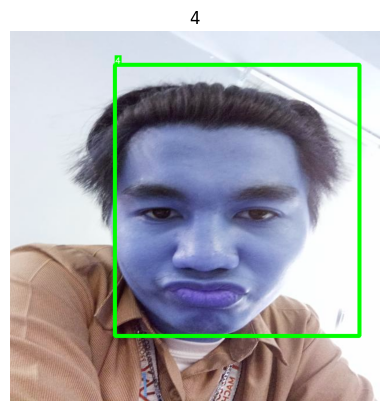

In [ ]:
index = 20
img = X_test[20]

# Rescale the bounding box predictions (back to original size)
img_height, img_width, _ = img.shape
predicted_bbox = y_bbox_pred[index]

# Convert normalized bbox to pixel coordinates (0 to img_width / img_height)
x_center = predicted_bbox[0] * img_width
y_center = predicted_bbox[1] * img_height
width = predicted_bbox[2] * img_width
height = predicted_bbox[3] * img_height

# Get the top-left and bottom-right corners of the bounding box
x1 = int(x_center - width / 2)
y1 = int(y_center - height / 2)
x2 = int(x_center + width / 2)
y2 = int(y_center + height / 2)

# Show the predicted class
predicted_class = np.argmax(y_cls_pred, axis=1)
predicted_class_name = class_ids[predicted_class[index]]

img = cv2.resize(img, image_size)
img_display = (img * 255).astype(np.uint8).copy()

color = (0, 255, 0)  # Green box
thickness = 5

# Draw rectangle
cv2.rectangle(img_display, (x1, y1), (x2, y2), color, thickness)

# Choose font
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

# Get text size to draw background
(text_width, text_height), _ = cv2.getTextSize(str(predicted_class_name), font, font_scale, font_thickness)

# Draw filled rectangle behind text
cv2.rectangle(img_display, (x1, y1 - text_height - 4), (x1 + text_width, y1), color, -1)

# Draw text (white text on top of the box)
cv2.putText(img_display, str(predicted_class_name), (x1, y1 - 2), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

plt.imshow(img_display)
plt.axis("off")
plt.title(predicted_class_name)
plt.show()

## Predict on test data

In [ ]:
y_pred = model.predict(X_test)

# Separate the predictions
y_cls_pred = y_pred[0]  # Class probabilities
y_bbox_pred = y_pred[1]  # Bounding box predictions

# Find the predicted class for each sample
predicted_classes = np.argmax(y_cls_pred, axis=1)

# Compare with true class labels (just for class prediction)
true_classes = np.argmax(y_cls_test, axis=1)

# Calculate accuracy (for class prediction)
class_accuracy = np.mean(predicted_classes == true_classes)
print(f"Class prediction accuracy: {class_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Class prediction accuracy: 0.84


## Save the model

In [ ]:
model.save('model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp5mlutth8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  List[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  134566797011152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566797011920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794040080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566797011344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794038928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794038352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794041040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794042192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794039312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134566794040272: Ten